In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
import polars as pl
os.environ['POLARS_MAX_THREADS'] = '32'

In [34]:
file = "/nfs/cds-peta/exports/biol_micro_cds_gr_sunagawa/scratch/vbezshapkin/tm-vec/tmvec_data/train_matched.parquet"
df = pl.read_parquet(file)
# df_example = pd.read_parquet("/nfs/cds-peta/exports/biol_micro_cds_gr_sunagawa/scratch/vbezshapkin/tm-vec/tmvec_data/train.parquet")

In [36]:
# get query and target sequence length
df = df.with_columns(pl.col("seq_query").str.len_chars().alias("len_query"),
                        pl.col("seq_target").str.len_chars().alias("len_target"))

In [37]:
# filter out sequences larger than 1024
df = df.filter(pl.col("len_query") <= 1024)
df = df.filter(pl.col("len_target") <= 1024)

In [38]:
# extract id from filepath
df = df.with_columns(pl.col("filepath_query").str.split("/").map_elements(lambda s: s[-1].split(".")[0]).alias("query_id"))
df = df.with_columns(pl.col("filepath_target").str.split("/").map_elements(lambda s: s[-1].split(".")[0]).alias("target_id"))

/tmp/ipykernel_3748104/830298884.py:2: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
  df = df.with_columns(pl.col("filepath_query").str.split("/").map_elements(lambda s: s[-1].split(".")[0]).alias("query_id"))
/tmp/ipykernel_3748104/830298884.py:3: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
  df = df.with_columns(pl.col("filepath_target").str.split("/").map_elements(lambda s: s[-1].split(".")[0]).alias("target_id"))


In [43]:
# get unique query id and query sequences
unique_query = df.select(["query_id", "seq_query"]).unique()
# get unique target
unique_target = df.select(["target_id", "seq_target"]).unique()
unique_target.columns = ["query_id", "seq_query"]

# concatenate
unique_query = unique_query.vstack(unique_target)

In [47]:
with open("/nfs/cds-peta/exports/biol_micro_cds_gr_sunagawa/scratch/vbezshapkin/tm-vec/tmvec_data/train_matched.fasta", "w") as f:
    for query_id, seq in unique_query.unique().to_pandas().values:
        f.write(f">{query_id}\n{seq}\n")

In [32]:
df[["query_id", "target_id", "tm_avg"]].write_csv("/nfs/cds-peta/exports/biol_micro_cds_gr_sunagawa/scratch/vbezshapkin/tm-vec/tmvec_data/train_matched.csv",
                                                  separator="\t", include_header=False)

In [4]:
from Bio.Align import PairwiseAligner

def identity(alignment):
    s = np.array(alignment)
    matches = (s[0] == s).all(axis=0)
    seq_id = 100 * matches.sum() / len(alignment[0])
    return seq_id

def sequence_identity(seq1, seq2):
    """
    Aligns two sequences and returns the sequence identity in percent.
    """
    aligner = PairwiseAligner()
    aligner.mode = 'global'
    alignments = aligner.align(seq1, seq2)
    seq_id = identity(alignments[0])
    return seq_id

In [5]:
# calculate average tm_score
df = df.with_columns(
    pl.concat_list(['tm_query', 'tm_target']).list.mean()
    .alias("tm_avg")
)

In [6]:
# apply sequence identity function
df = df.with_columns(
    pl.struct(["seq_query", "seq_target"])
    .map_elements(lambda x: sequence_identity(x["seq_query"], x["seq_target"]), return_dtype=pl.Float64).alias("seq_id")
)

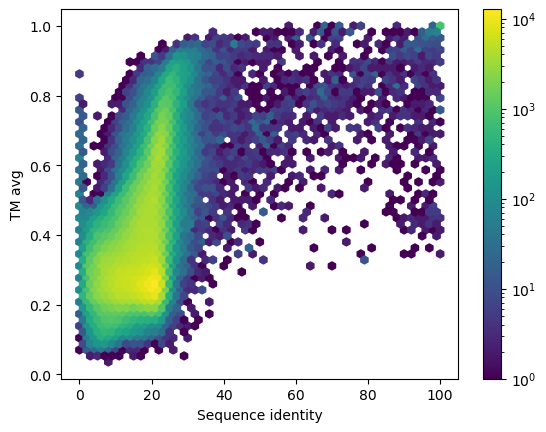

In [13]:
# 2D histogram with density of tm avg vs seq_id
# log norm
from matplotlib.colors import LogNorm

fig, ax = plt.subplots()
hb = ax.hexbin(df["seq_id"], df["tm_avg"], gridsize=50, cmap="viridis", norm=LogNorm())
ax.set_ylabel("TM avg")
ax.set_xlabel("Sequence identity")
fig.colorbar(hb, ax=ax)
plt.show()

In [15]:
add_df = pl.read_parquet("/nfs/cds-peta/exports/biol_micro_cds_gr_sunagawa/scratch/vbezshapkin/tm-vec/tmvec_data/valid.parquet")

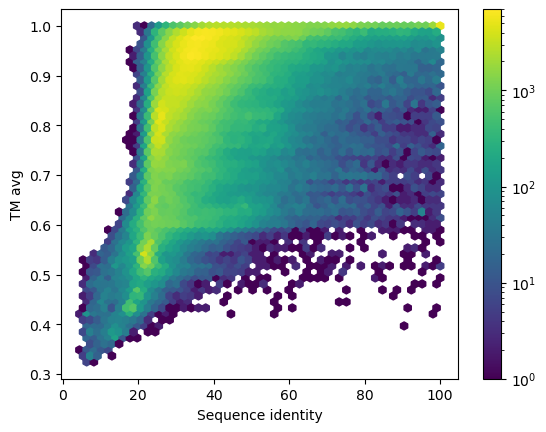

In [16]:
# make a 2D histogram with density of tm avg vs seq_id

fig, ax = plt.subplots()
hb = ax.hexbin(add_df["seq_id"], add_df["tm_avg"], gridsize=50, cmap="viridis", norm=LogNorm())
ax.set_ylabel("TM avg")
ax.set_xlabel("Sequence identity")
fig.colorbar(hb, ax=ax)
plt.show()

In [2]:
valid_df = "/nfs/cds-peta/exports/biol_micro_cds_gr_sunagawa/scratch/vbezshapkin/tm-vec/tmvec_data/train_matched.parquet"

valid_df = pl.read_parquet(valid_df)

NameError: name 'LogNorm' is not defined

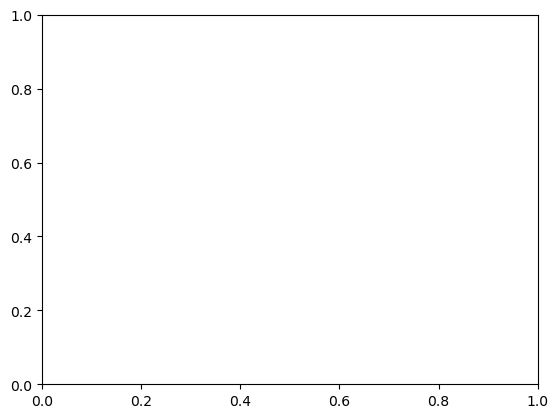

In [4]:
# plot a 2d histrogram
fig, ax = plt.subplots()
hb = ax.hexbin(valid_df["seq_id"], valid_df["tm_avg"], gridsize=50, cmap="viridis", norm=LogNorm())
ax.set_ylabel("TM avg")
ax.set_xlabel("Sequence identity")
fig.colorbar(hb, ax=ax)
plt.show()
